In [1]:
# Perform the initialization and imports
import sys
import pickle
import re
import os
import csv
import argparse
import math
import pprint

from string import ascii_lowercase
from collections import Counter, defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from Bio import SeqIO, AlignIO
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC
from Bio.Seq import Seq
from Bio.Emboss.Applications import NeedleallCommandline

# Demand Python 3.
if sys.version_info[0] < 3:
    print("Python 3 is required, but you are using Python %i.%i.%i") % (
        sys.version_info[0], sys.version_info[1], sys.version_info[2])
    sys.exit(1)

In [2]:
# Retrieve the specific functions from ind and proteins.py
indels_path="/home/maya/InDelScanner"  # /PATH/TO/InDelScanner
if indels_path not in sys.path:
    sys.path.append(indels_path)
from indels.ind import trim_read, findEnds, endMatch, findGap, gapAlign

In [3]:
os.chdir("/mnt/c/Users/Maya/Dropbox/mek_results")

with open('Remkes_protein.p', 'rb') as f:
    all_ref = pickle.load(f)
with open('Remkes_protein_low.p', 'rb') as f:
    low = pickle.load(f)

all_ref['mek']['low-v2'] = low['mek']['low-v2']

mek = {}
for fraction in ['high', 'med']:
    mek[fraction] = Counter(all_ref['mek'][fraction])
mek['low-t'] = Counter(all_ref['mek']['low']) + Counter(all_ref['mek']['low-v2'])

In [4]:
df_all = pd.DataFrame.from_dict(mek).fillna(0).sort_values(by=['high', 'med', 'low-t'], ascending=False).astype(int)
df_50p = df_all.loc[(df_all['high'] >= 50) & ((df_all['high']+df_all['med']) > 2*df_all['low-t'])]
df_20to50 = df_all.loc[(df_all['high'].isin(range(10,50))) & 
                       (df_all['high'] > df_all['med']) & 
                       ((df_all['high']+df_all['med']) > 5*df_all['low-t']) ]

In [5]:
df_pos = df_50p.append(df_20to50)
pos = df_pos.to_dict()
df_pos.describe()

,high,med,low-t
count,32377.000000,32377.000000,32377.000000
mean,136.646292,11.121352,10.631251
std,89.495014,15.084813,8.148840
min,10.000000,0.000000,0.000000
25%,77.000000,0.000000,5.000000
50%,116.000000,3.000000,9.000000
75%,171.000000,18.000000,15.000000
max,1185.000000,162.000000,69.000000


Here, the filtering steps have been completed: the result is a dataset with 32,4K variants that we are confident to call active MEK1 variants. Next, I use these variants to explore the enrichment of different amino acids amongst positive variants.

## 1D enrichment pie charts and heat maps

In [6]:
from ipynb.fs.defs.Kinase_statistics import make_composition_plot_per_position, single_fraction_enrichment

In [7]:
aa_order = ['A','G','P','Y','D','K','M','V','I','L','F','W','Δ']
valid_pos = ['6', '7a', '8a', '9', '11', '13']

The first plot is special, and is used to set up later plots.

In [8]:
pos_e = single_fraction_enrichment(pos, 'high', 1, proportion=False) # all variants contribute equally
df_enr = pd.DataFrame.from_dict(pos_e).reindex(aa_order) # reindex to get a sensible colour scheme
df_enr

,6,7a,8a,9,11,13
A,1825,1374,15427,1389,1127,2256
G,2058,1411,0,922,920,1539
P,3412,3241,0,2297,1285,2313
Y,2185,1393,0,1625,1453,1666
D,972,606,0,1054,981,1586
K,2501,2209,0,1598,1144,1911
M,3015,1680,0,3403,2547,3203
V,2197,2154,0,1876,2600,3401
I,2496,5133,0,4886,6487,4360
L,4806,6866,0,7565,7870,3443


In [9]:
restrictions  = [[{'7a':['A', 'D', 'F', 'G', 'I', 'K', 'L', 'M', 'P', 'V', 'W', 'Y'], '8a':['A']}, '7aX 8aA'],
                 [{'7a':['Δ'], '8a':['Δ']}, '7aΔ 8aΔ'],
                 [{'9':['L'], '11':['L']}, '9L 11L'],
                 [{'9':['I'], '11':['L']}, '9I 11L'],
                 [{'9':['L'], '11':['I']},'9L 11I'],
                 [{'9':['I'], '11':['I']}, '9I 11I'],
                 [{'9':['I', 'L'], '11':['I','L']},'9 I/L\n11 I/L'],
                 [{'9': ['A', 'D', 'F', 'G', 'K', 'M', 'P', 'V', 'W', 'Y'], 
                   '11':['A', 'D', 'F', 'G', 'K', 'M', 'P', 'V', 'W', 'Y']}, '9 no I/L\n11 no I/L']
                 ]

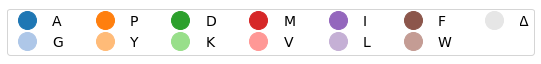

In [10]:
# Set palette and the order of amino acids for meaningful colors
pal = sns.color_palette("tab20")[:13]
pal[12] = (0.9, 0.9, 0.9) # set deletion to gray
sns.set_palette(pal)

fig, ax = plt.subplots(1,1, figsize=(1,1))
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in pal]
fig.legend(markers, aa_order, numpoints=1, loc='center left', ncol=7, markerscale=3, fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.savefig('Pie_legend.svg')
plt.show()

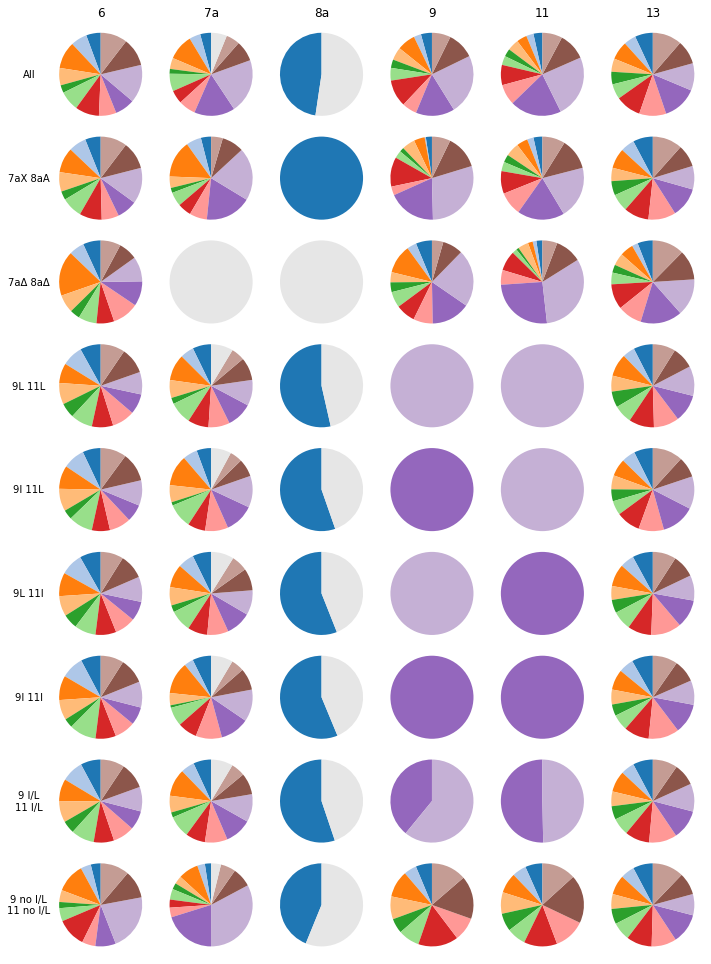

In [11]:
fig, axes = plt.subplots(len(restrictions)+1,6, 
                         figsize=(10,(len(restrictions)+1)*1.5),
                         gridspec_kw={'hspace': 0, 'wspace': 0})

# the first row is special and plots the unfiltered variants
row = 0
for i in range(len(valid_pos)):
    axes[row][i].set_title(valid_pos[i])
    axes[row][i].pie(df_enr[valid_pos[i]], startangle=90)
    if i == 0:
        axes[row][i].set_ylabel('All', rotation='horizontal', labelpad=20, va='center')

# then we loop over the restrictions
for row in range(1,len(restrictions) +1):
    cnts = single_fraction_enrichment(pos, 'high', 1, restrictions[row-1][0], proportion=False)
    df_restrict = pd.DataFrame.from_dict(cnts).reindex(aa_order)
    for i in range(len(valid_pos)):
        axes[row][i].pie(df_restrict[valid_pos[i]], startangle=90)
        if i == 0:
            axes[row][i].set_ylabel(restrictions[row-1][1], rotation='horizontal', labelpad=20, va='center')

plt.tight_layout()
plt.savefig('Pie_plots.svg')
plt.show()

### Generate arrays for 15 cross-position enrichments

In [12]:
from ipynb.fs.defs.Kinase_statistics import convert_variant_to_dict

In [13]:
# Set palette and the order of amino acids for meaningful colors
aa_2 = ['A', 'Δ']
aa_12 = ['A','G','P','Y','D','K','M','V','I','L','F','W']
aa_13 = aa_12 +  ['Δ']
pos_aa = {'6': aa_12, '9': aa_12, '11': aa_12, '13': aa_12, '7a': aa_13, '8a': aa_2}

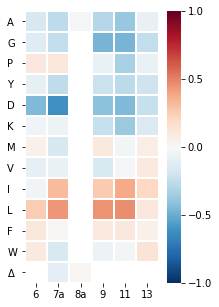

In [133]:
crange=[-1, 1]
fig, axes = plt.subplots(1,1, figsize=(3,5))

# the first row is special and plots the unfiltered variants
ax = axes
log_enr = (df_enr/(df_enr.sum()/df_enr.astype(bool).sum())).apply(np.log10)   
sns.heatmap(log_enr, vmin=crange[0], vmax=crange[1], linewidths=1, ax=ax, cmap="RdBu_r", 
            cbar=True, cbar_kws={'ticks': [-1.0, -0.5, 0, 0.5, 1.0]})
#ax.set_title('High binding - All curated sequences')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='left')
ax.tick_params(axis='y', which='major', pad=14)

plt.savefig('1D_heatmap_-1to1.svg')
plt.show()

In [15]:
def two_position_enrichment(input, proportion=True):
    """
    input: a Counter 
    posA, posB: two positions between which to generate a heatmap
    """    
    counts = {
        posA : {
            aaA : {
                posB : {
                    aaB: 0 for aaB in pos_aa[posB]}
                for posB in valid_pos}
            for aaA in pos_aa[posA]}
        for posA in valid_pos}

    for mutation_string, count in input.items():
         # m_by_pos[position] = AA
        m_by_pos = convert_variant_to_dict(mutation_string)
        # check the mutations is one we're interested in
        observed_aa = set(m_by_pos.values())
        if not observed_aa.issubset(aa_13):
            continue
                
        if proportion:
            c = count
        else:
            c = 1
                
        # here this becomes similar as for single enrichments, except we need to loop twice
        for posA, aaA in m_by_pos.items():
            for posB, aaB in m_by_pos.items():
                counts[posA][aaA][posB][aaB] += c

    return counts

In [16]:
cross_e = two_position_enrichment(pos['high'])

In [17]:
cross_dfs = {posA : {posB : "" for posB in valid_pos} for posA in valid_pos}

for posA in valid_pos:
    for posB in valid_pos:
        dict_data = {aaA : [cross_e[posA][aaA][posB][aaB] for aaB in pos_aa[posB]] for aaA in pos_aa[posA]}
        cross_dfs[posA][posB] = pd.DataFrame.from_dict(dict_data, orient='index', columns=pos_aa[posB])

In [18]:
log_dfs = {}
joint_dfs = {}

for posA in valid_pos:
    log_dfs[posA] = {}
    joint_dfs[posA] = {}
    for posB in valid_pos:
        total = cross_dfs[posA][posB].sum().sum()
        cells = len(pos_aa[posA]) * len(pos_aa[posB])
        avg_cnt = total/cells
        
        joint_dfs[posA][posB] = cross_dfs[posA][posB]/total
        log_dfs[posA][posB] = (cross_dfs[posA][posB]/avg_cnt).apply(np.log10)    

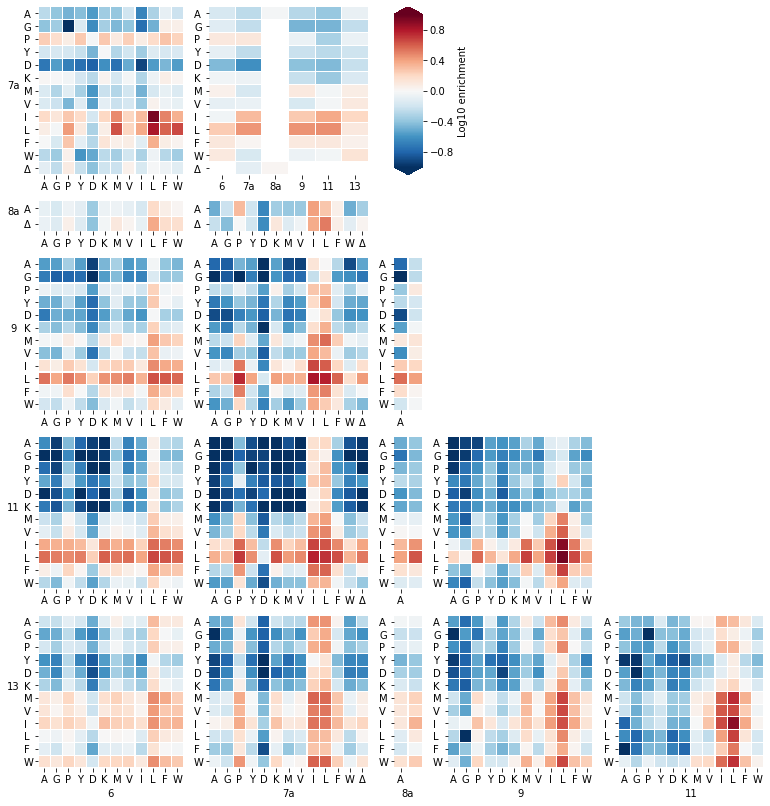

In [93]:
fig, axes = plt.subplots(5, 5, figsize=(13,14),
                         gridspec_kw={'width_ratios': [2,2.2,0.4,2,2],'height_ratios': [2.2,0.4,2,2,2],
                                     'wspace':0.2, 'hspace':0.2})
# figsize (width, height)
# top left axes = axes[0,0]
# top row, middle = axes[0,2]

crange=[-1, 1]

for a in range(len(valid_pos)): # a = row index, running from 0 to 4
    for b in range(len(valid_pos)): # b = column index, running from 0 to 4
        if (b == 5) or (a == 0):
            continue
        elif b >= a:
            axes[a-1][b].axis('off')
            continue
        ax = axes[a-1][b]
        im = sns.heatmap(log_dfs[valid_pos[a]][valid_pos[b]], vmin=crange[0], vmax=crange[1], linewidths=0.1, ax=ax, 
                        cmap="RdBu_r", cbar_ax=axes[0][2], cbar_kws={'label': 'Log10 enrichment', 'extend': 'both'}) # all colorbars are plotted to the same axes
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='left')
        ax.tick_params(axis='y', which='major', pad=11)
        if a == 5:
            ax.set_xlabel(valid_pos[b])
        if b == 0:
            ax.set_ylabel(valid_pos[a], rotation=0, labelpad=10)

# colorbar formatting
axes[0][2].axis('on')

# add the 1D plot in top right corner
ax = axes[0][1]
ax.axis('on')
log_enr = (df_enr/(df_enr.sum()/df_enr.astype(bool).sum())).apply(np.log10)   
sns.heatmap(log_enr, vmin=crange[0], vmax=crange[1], linewidths=0.1, ax=ax, cmap="RdBu_r", cbar=False)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='left')
ax.tick_params(axis='y', which='major', pad=11)

fig.align_labels()

#plt.tight_layout()
plt.savefig('2D_joint_heatmaps_-1to1.svg')
plt.show()

The enrichment of variants compared to evenly distributed library: $log(\frac{freq_{xy}}{ideal_{xy}})$. 1D plot: $log(\frac{freq_{x}}{ideal_{x}})$

In [20]:
log_col_dfs = {}

for posA in valid_pos:
    log_col_dfs[posA] = {}
    for posB in valid_pos:
        log_col_dfs[posA][posB] = (cross_dfs[posA][posB]/(cross_dfs[posA][posB].sum()/cross_dfs[posA][posB].astype(bool).sum(axis=0))).apply(np.log10)

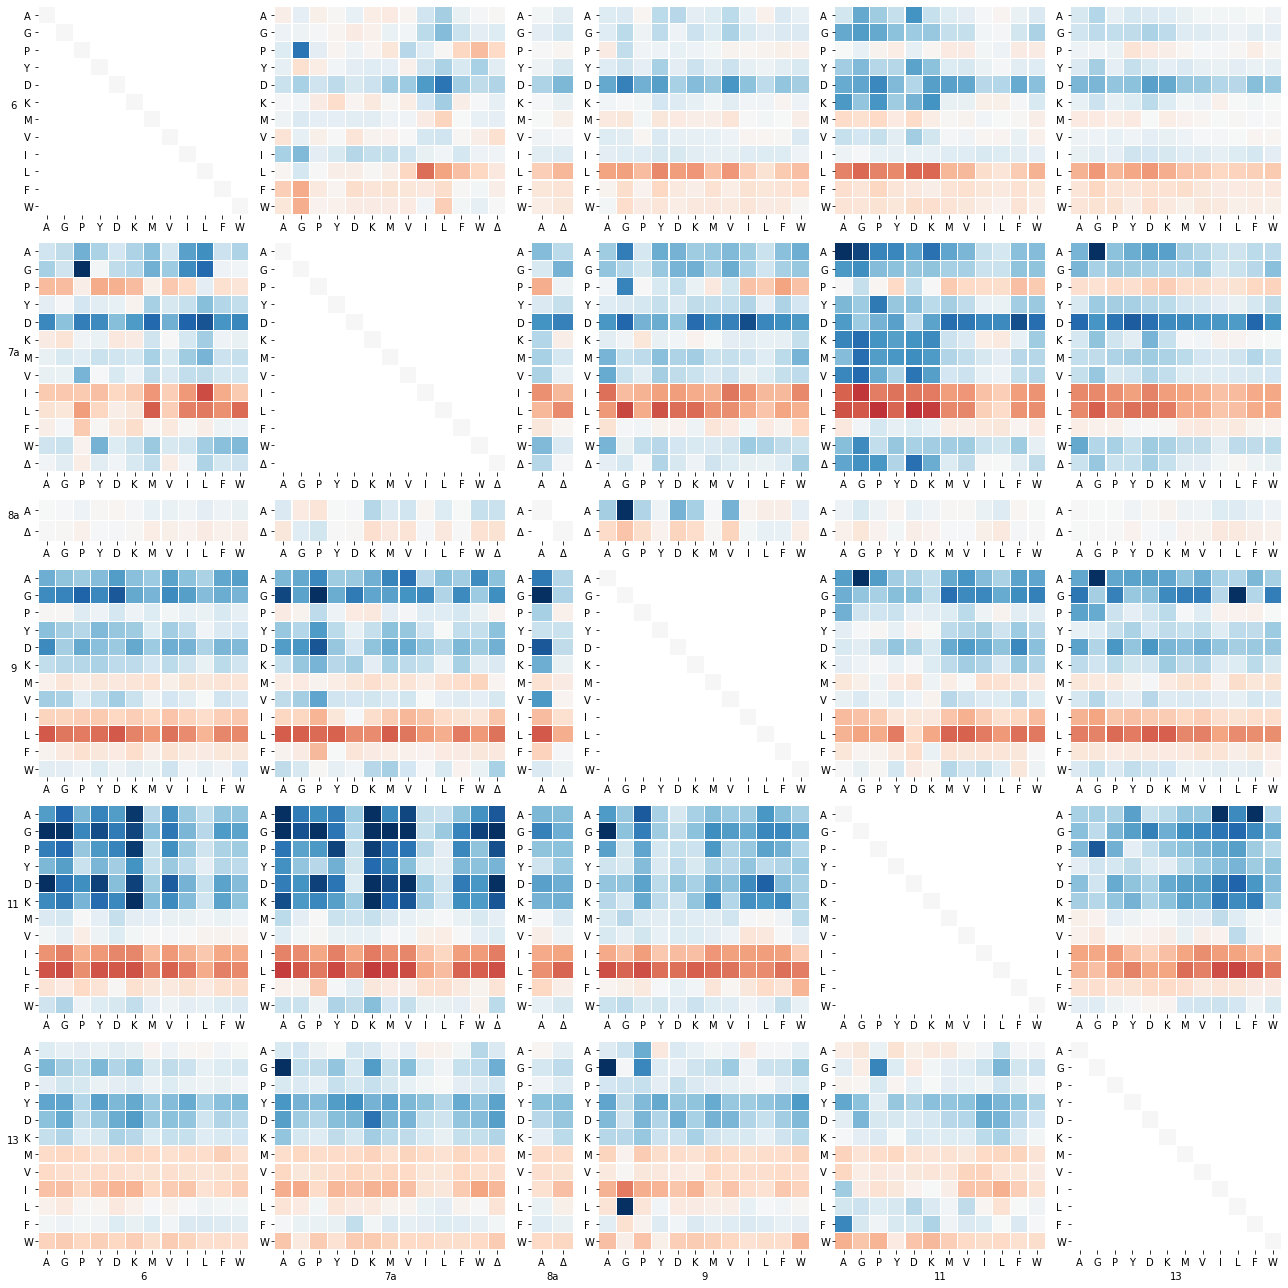

In [80]:
fig, axes = plt.subplots(6, 6, figsize=(18,18),
                        gridspec_kw={'width_ratios': [2,2.2,0.4,2,2,2],'height_ratios': [2,2.2,0.4,2,2,2]})

# top left axes = axes[0,0]
# top row, middle = axes[0,2]

for a in range(len(valid_pos)): # a = row index, running from 0 to 4
    for b in range(len(valid_pos)): # b = column index, running from 0 to 4
        ax = axes[a][b]
        sns.heatmap(log_col_dfs[valid_pos[a]][valid_pos[b]], vmin=crange[0], vmax=crange[1], linewidths=0.1, ax=ax, 
                    cmap="RdBu_r", cbar=False)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='left')
        ax.tick_params(axis='y', which='major', pad=11)
        # set labels on the outer edges
        if b == 0:
            ax.set_ylabel(valid_pos[a], rotation=0, labelpad=10)
        if a == 5:
            ax.set_xlabel(valid_pos[b])


plt.tight_layout()
plt.savefig('2D_conditional_heatmap_-1to1.svg')
plt.show()

The conditional dependence of amino acid preference between six randomised positions.

## Mutual information plots

In [23]:
mi_ideal_dfs = {posA : {posB : "" for posB in valid_pos} for posA in valid_pos}
df_1D = df_enr/df_enr.sum()

for posA in valid_pos:
    for posB in valid_pos:
        dict_data = {}
        for aaA in pos_aa[posA]:
            f_a = df_1D[posA][aaA]
            dict_data[aaA] = []
            for aaB in pos_aa[posB]:
                f_b =df_1D[posB][aaB]
                try:
                    dict_data[aaA].append(f_a*f_b)
                except ValueError:
                    dict_data[aaA].append(np.nan)
        mi_ideal_dfs[posA][posB] = pd.DataFrame.from_dict(dict_data, orient='index', columns=pos_aa[posB])

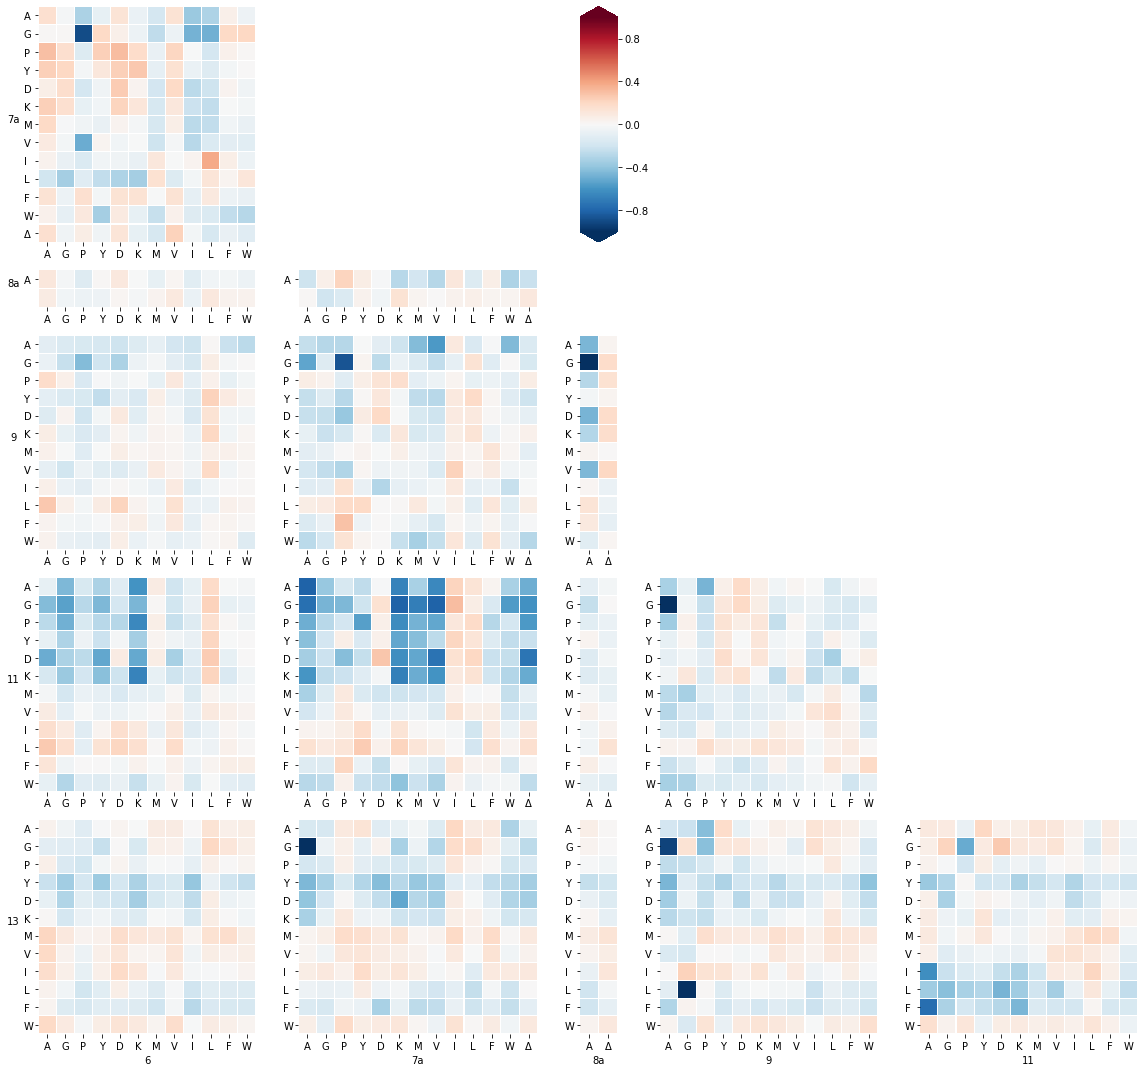

In [105]:
fig, axes = plt.subplots(5, 5, figsize=(16,15),
                         gridspec_kw={'width_ratios': [2,2.2,0.35,2,2],'height_ratios': [2.2,0.35,2,2,2]})
mi_lim = [-1, 1]
for a in range(len(valid_pos)): # a = row index, running from 0 to 4
    posA = valid_pos[a]
    for b in range(len(valid_pos)): # b = column index, running from 0 to 4
        posB = valid_pos[b]
        if (b == 5) or (a == 0):
            continue
        elif b >= a:
            axes[a-1][b].axis('off')
            continue
        ax = axes[a-1][b]
        df = (joint_dfs[posA][posB]/mi_ideal_dfs[posA][posB]).apply(np.log10)
        sns.heatmap(df, linewidths=0.1, ax=ax, vmin=mi_lim[0], vmax=mi_lim[1], center=0,
                        cmap="RdBu_r", cbar_ax=axes[0][2], cbar_kws={'label': '', 'extend': 'both'}) # all colorbars are plotted to the same axes
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='left')
        ax.tick_params(axis='y', which='major', pad=11)
        # set labels on the outer edges
        if b == 0:
            ax.set_ylabel(valid_pos[a], rotation=0, labelpad=10)
        if a == 5:
            ax.set_xlabel(valid_pos[b])

# colorbar formatting
axes[0][2].axis('on')

plt.tight_layout()
#plt.savefig('2D_epistasis_-0.2to0.2.svg')

plt.show()

Suggestive of anchorage effects in I/L in positions 7a, 9 and 11, and MVIW in 13.

In [110]:
cross_e['6']['P']['7a']['G']

2608

## Zoom in on beneficial epistasis

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(16,15),
                         gridspec_kw={'width_ratios': [2,2.2,0.35,2,2],'height_ratios': [2.2,0.35,2,2,2]})
mi_lim = [-1, 1]
for a in range(len(valid_pos)): # a = row index, running from 0 to 4
    posA = valid_pos[a]
    for b in range(len(valid_pos)): # b = column index, running from 0 to 4
        posB = valid_pos[b]
        if (b == 5) or (a == 0):
            continue
        elif b >= a:
            axes[a-1][b].axis('off')
            continue
        ax = axes[a-1][b]
        df = (joint_dfs[posA][posB]/mi_ideal_dfs[posA][posB]).apply(np.log10)
        df[df < 0] = np.nan
        sns.heatmap(df, linewidths=0.1, ax=ax, vmin=mi_lim[0], vmax=mi_lim[1], center=0,
                        cmap="RdBu_r", cbar_ax=axes[0][2], cbar_kws={'label': '', 'extend': 'both'}) # all colorbars are plotted to the same axes
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='left')
        ax.tick_params(axis='y', which='major', pad=11)
        # set labels on the outer edges
        if b == 0:
            ax.set_ylabel(valid_pos[a], rotation=0, labelpad=10)
        if a == 5:
            ax.set_xlabel(valid_pos[b])

# colorbar formatting
axes[0][2].axis('on')

plt.tight_layout()
#plt.savefig('2D_epistasis_-0.2to0.2.svg')

plt.show()

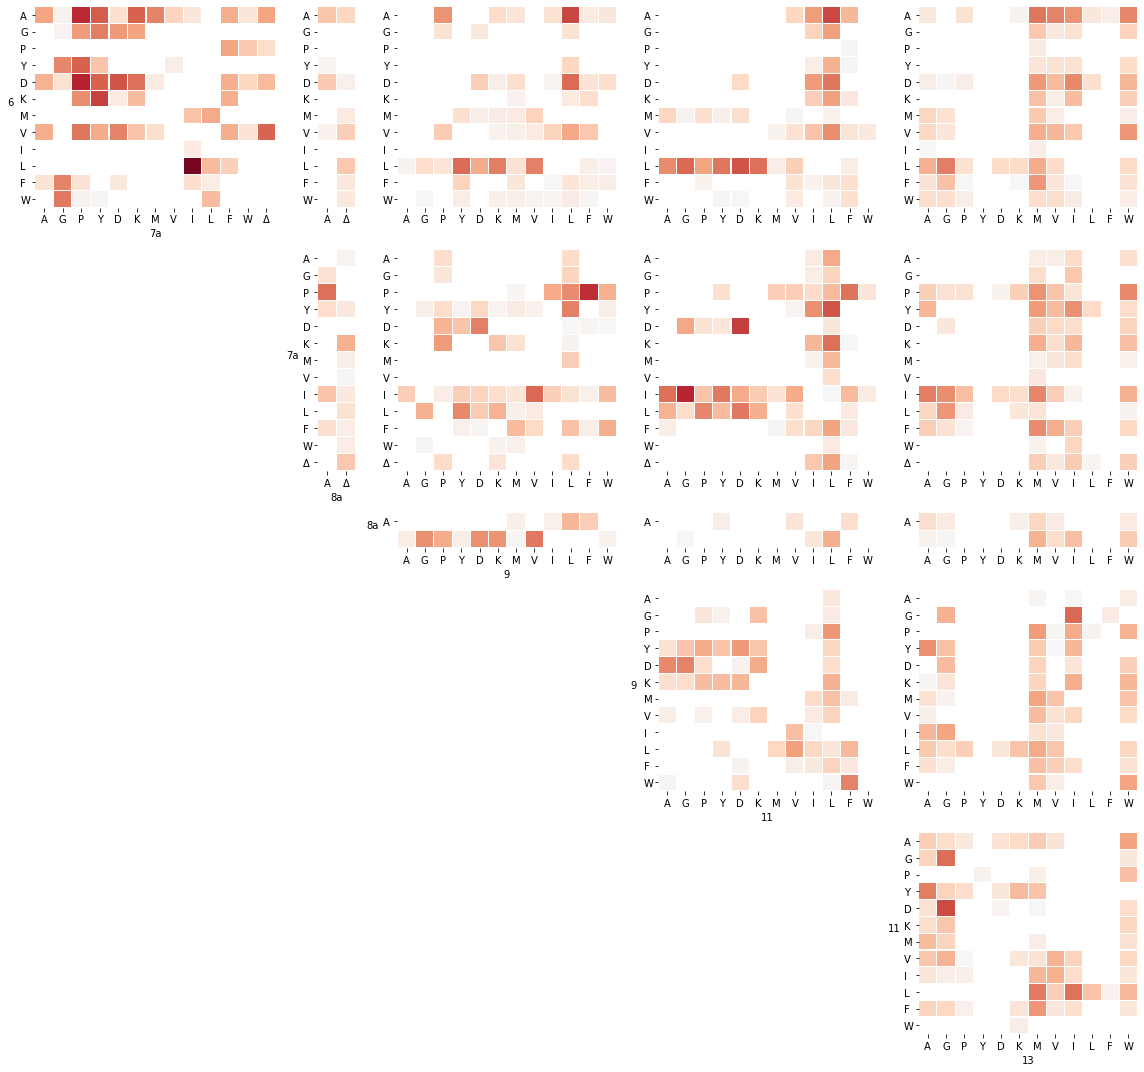

In [144]:
fig, axes = plt.subplots(5, 5, figsize=(16,15),
                         gridspec_kw={'height_ratios': [2,2.2,0.35,2,2],'width_ratios': [2.1,0.35,2,2,2]})
mi_lim = [-0.4, 0.4]
for a in range(len(valid_pos)): # a = row index, running from 0 to 4
    posA = valid_pos[a]
    for b in range(len(valid_pos)): # b = column index, running from 0 to 4
        posB = valid_pos[b]
        if (b == 0) or (a == 5):
            continue
        elif b <= a:
            axes[a][b-1].axis('off')
            continue
        ax = axes[a][b-1]
        df = (joint_dfs[posA][posB]/mi_ideal_dfs[posA][posB]).apply(np.log10)
        df[df < 0] = np.nan
        sns.heatmap(df, linewidths=0.1, ax=ax, vmin=mi_lim[0], vmax=mi_lim[1], center=0,
                        cmap="RdBu_r", cbar=False) # all colorbars are plotted to the same axes
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='left')
        ax.tick_params(axis='y', which='major', pad=11)
        # set labels on the outer edges
        if a == (b-1):
            ax.set_ylabel(valid_pos[a], rotation=0, labelpad=10)
            ax.set_xlabel(valid_pos[b])

# colorbar formatting
axes[0][2].axis('on')

plt.tight_layout()
#plt.savefig('2D_epistasis_positive_0to0.4.svg')

plt.show()

Suggestive of anchorage effects in I/L in positions 7a, 9 and 11, and MVIW in 13.

## Zooming in on the I/L and the effect of insertions

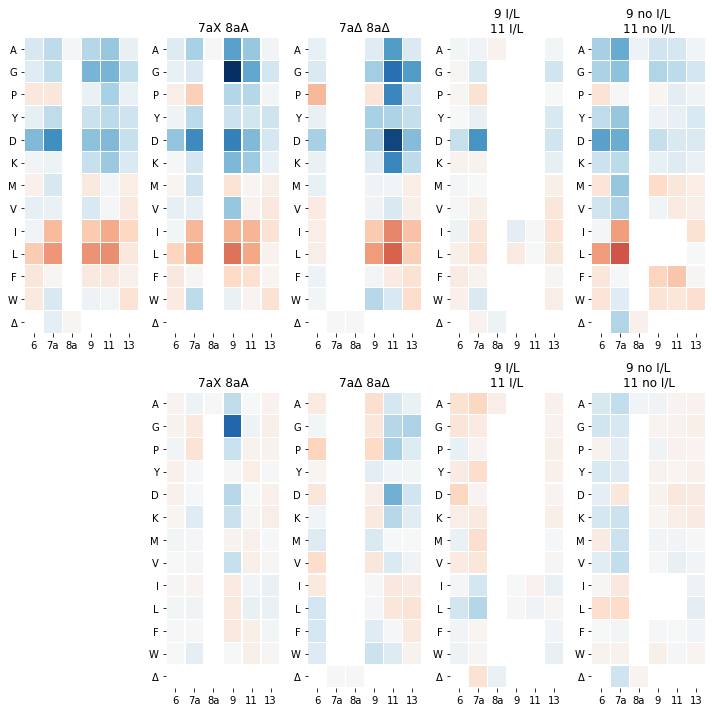

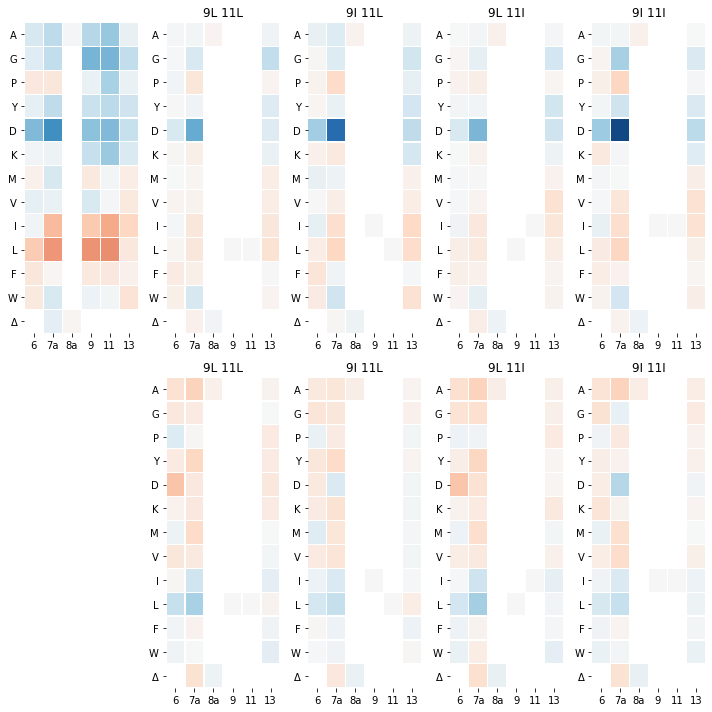

In [59]:
r1 = restrictions[:2] + restrictions[6:]
r2 = restrictions[2:6]

crange=[-1, 1]

for  rest in (r1, r2):
    fig, axes = plt.subplots(2, len(rest) +1,  figsize=(10,10))
    
    # add the 1D unrestricted plot
    log_enr = (df_enr/(df_enr.sum()/df_enr.astype(bool).sum())).apply(np.log10)   
    sns.heatmap(log_enr, vmin=crange[0], vmax=crange[1], linewidths=0.1, ax=axes[0][0], cmap="RdBu_r", cbar=False)
    axes[1][0].axis('off')

    for i in range(1,len(rest)+1):
        r = i-1
        cnts = single_fraction_enrichment(pos, 'high', 1, rest[r][0], proportion=False)
        df_restrict = pd.DataFrame.from_dict(cnts).reindex(aa_order)

        # left plot: normalise the df relative to even library
        log_df = (df_restrict/(df_restrict.sum()/df_restrict.astype(bool).sum())).apply(np.log10)   
        sns.heatmap(log_df, vmin=crange[0], vmax=crange[1], linewidths=0.2, ax=axes[0][i], cmap="RdBu_r", cbar=False)
        axes[0][i].set_title(rest[r][1])

        # right plot: normalise the df relative to df_enr (unrestricted)
        top_df = df_restrict/df_restrict.sum()
        mask = df_restrict.astype(bool)
        b_df = df_enr.where(mask)/ df_enr.where(mask).sum()
        log_df = (top_df/b_df).apply(np.log10)   
        sns.heatmap(log_df, vmin=crange[0], vmax=crange[1], linewidths=0.2, ax=axes[1][i], cmap="RdBu_r",  cbar=False)
        axes[1][i].set_title(rest[r][1])
    
    for ax in axes.flat:
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    plt.tight_layout()

    plt.show()